<a href="https://colab.research.google.com/github/Prachiy031/FinalYearProject/blob/main/ksdImple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing All Libraries

In [ ]:
from google.colab import drive     # mounted to drive so to access everything from drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1


In [ ]:
!pip install --upgrade tensorflow keras


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gradio as gr
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



**Preparing For Data**

In [ ]:
folder_path = "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train"
filenames = []      #stores relative paths of image
categories = []     #stores category/label of image...e.g. stone ,normal

for category in os.listdir(folder_path):    #gets a list of all subfolders inside Train
    category_path = os.path.join(folder_path, category)  #joins folder path and each category in category folder

    if os.path.isdir(category_path):  #valid directory
        for filename in os.listdir(category_path):   #loop through all images in category_path
            filenames.append(os.path.join(category, filename))    #joins filename to category and append it to filenames list
            categories.append(category)   #category is appended to categories list

df = pd.DataFrame({            #structured dataframe
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()             #top 5 entries

,filename,category
0,Stone/Stone- (104).jpg,Stone
1,Stone/Stone- (111).jpg,Stone
2,Stone/Stone- (108).jpg,Stone
3,Stone/Stone- (107).jpg,Stone
4,Stone/Stone- (11).jpg,Stone


In [ ]:
df.tail()          #last 5 entries

,filename,category
2995,Normal/Normal- (2148).jpg,Normal
2996,Normal/Normal- (215).jpg,Normal
2997,Normal/Normal- (2165).jpg,Normal
2998,Normal/Normal- (2144).jpg,Normal
2999,Normal/Normal- (2154).jpg,Normal


<Axes: xlabel='category'>

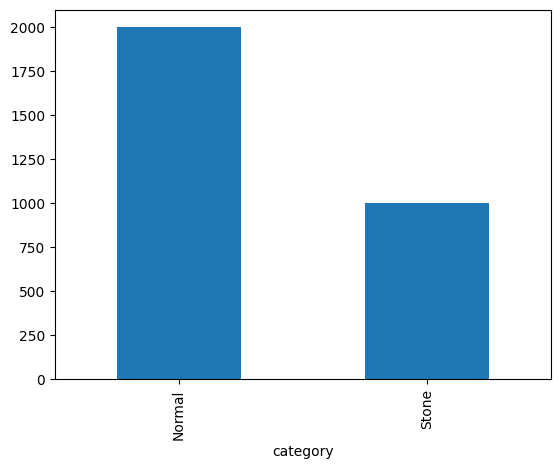

In [ ]:
df['category'].value_counts().plot.bar()

There are total 2000 normal and 1000 stone images in dataset

**Visualizing Data**

Selected file: Stone/Stone- (58).jpg
Selected image Size: 512 x 512 pixels


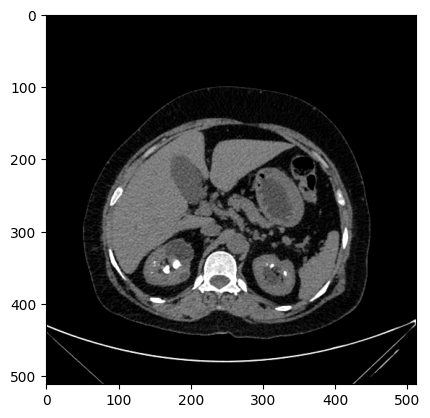

In [ ]:
from PIL import Image    #for displaying image size


sample = random.choice(filenames)    #selects random file from filenames list
print("Selected file:", sample)       #selected file
image_path = f"/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/{sample}"    #image path
image = load_img(image_path)       #reads an image (keras utility function)

# Open the image using PIL to get its size
with Image.open(image_path) as img:
    width, height = img.size
    print(f"Selected image Size: {width} x {height} pixels")


plt.imshow(image)  #renders an image in colab (matplotlib)

**Preparing Data=>Splitting data before augmentation to avoid data leakage**
1)split dataset into training set 80% and validation set 20%**

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


#random_state is set to 42 so that everytime we run the code ,train-test spilt will remain same, otherwise it will change
#also there will be no different model performance each time
#after splitting indices will be reset again starting from 0

<Axes: xlabel='category'>

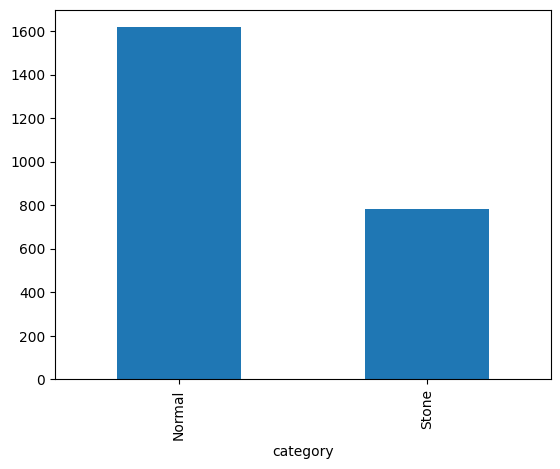

In [ ]:
train_df['category'].value_counts().plot.bar()

**for training there are 1600 normal images and 800 stone images**

<Axes: xlabel='category'>

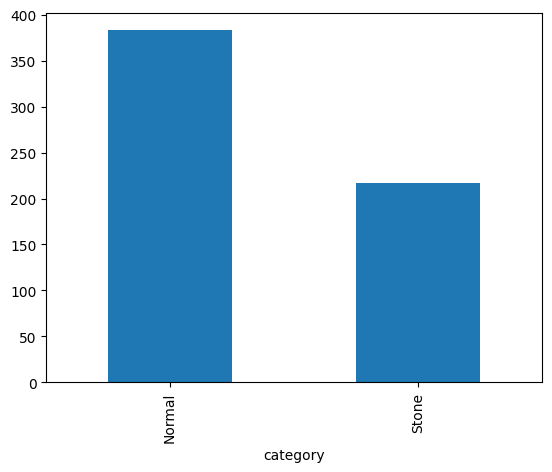

In [ ]:
validate_df['category'].value_counts().plot.bar()

**for validation there are 375 normal images and 225 stone images**

**Data Preprocessing**
with generator memory usage is less , data augmentation is auto and label handling is automatic and fast efficiency

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,          #randomly rotates image upto +-15 degree
    rescale=1./255,              #Scales pixel values to the range [0,1] (instead of [0,255]), which helps with faster and stable training.
    shear_range=0.1,      #Applies a shear transformation (tilts the image/skews image 10% distortion(small))
    zoom_range=0.2,       #Randomly zooms the image in or out by up to 20% --inc acc
    horizontal_flip=True, #Randomly flips images horizontally.
    width_shift_range=0.1,  #Shifts the image horizontally by up to 10%.
    height_shift_range=0.1,  #Shifts the image vertically by up to 10%
    brightness_range=[0.8, 1.2],  # Adjust brightness 0.8 image will be darker and 1.2 image will be brighter  --inc accuracy
)

#image data generator in keras is used for data augmentation which helps to increase the diversity of training images by applying random transformations
#improves model generalization and reduces overfitting.


#no augmentation for validation data as we dont want any noise in that data
#only rescaling will be done
validation_datagen = ImageDataGenerator(rescale=1./255)    #Converts pixel values from [0,255] to [0,1]

**create data generator train and validation**
1)with generator memory usage is less , data augmentation is auto and label handling is automatic and fast efficiency

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),     #resizes all images to 150*150
    class_mode='categorical',       #converts labels into one-hot encoded format
    batch_size=15   #generator loads images in batches of 15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),    #resizes all images to 150*150
    class_mode='categorical',    #converts labels into one-hot encoded format
    batch_size=15
)


#flow_from_dataframe uses a Pandas dataframe containing file names & labels.
#Can load images from multiple sources without changing directory structure.
# Allows custom class labels directly from a CSV or dataframe.

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


visualizing o/p of data generator

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)   #select one random image from train_df and reset index so that row will start from 0

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


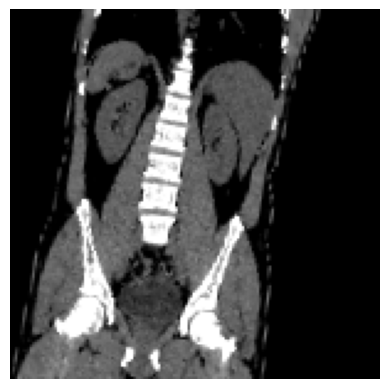

Class Label (One-Hot Encoded): [1.]


In [ ]:
#view randomly selected image
#to ensure data preprocessing(data augmentation) done correctly

# Get a batch (1 image) from the generator
image_batch, label_batch = next(example_generator)  #retrives next batch of images and labels
#image batch=>numpy array of images
#label_batch =>numpy array of one-hot encoded lables

# Display the image
plt.imshow(image_batch[0])      # Display first (and only) image
plt.axis("off")            # Hide axes
plt.show()

# Print the corresponding label
print("Class Label (One-Hot Encoded):", label_batch[0])


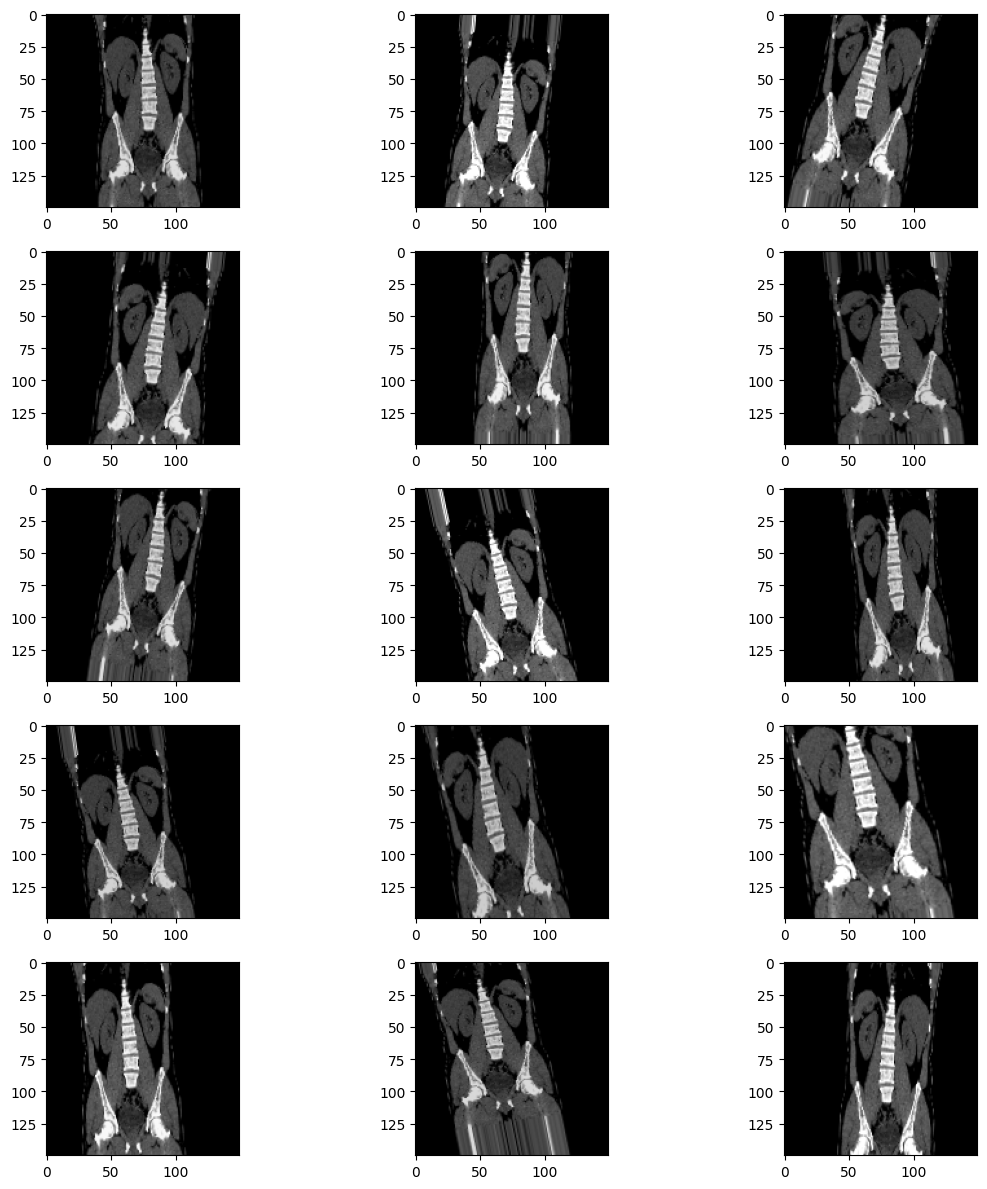

In [ ]:
#visualizes multiple(15) random images
plt.figure(figsize=(12, 12)) #sets size of entire fig 12*12 inches
for i in range(0, 15):   #displaying total 15 images
    plt.subplot(5, 3, i+1) #5 rows 3 colm
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()  #Ensure subplots do not overlap
plt.show()

**Building CNN Model**

In [ ]:
model = Sequential()      #model in linear stack of layers, each layer has exactly one i/p and o/p tensor

#Adding convolutional layers
# 32-no. of kernels/filters (3,3)- size of each filter activation function is relu for no-linearity
# i/p image of shape(150,150,3)...150*150 with 3 channels of RGB color images
#this layers applies 32 filters to i/p image eah with 3*3 in size to extract features like edges,textures,patterns
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())   #improve the training speed and stability of neural network---inc acc
model.add(MaxPooling2D(pool_size=(2, 2)))   #reduces the spatial dimensions(height and width) by selecting max value from 2*2 pool
#it encourages the model to focus on the most important features of the image, rather than memorizing detailed spatial information.
#selects max out of 2*2 widow size



#Adding a second convolutional layer
#with 64 filters/kernels    no need to mention i/p shape as it is inferred from prev layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors which are used in fully connected layers...3d vector with dim (h,w,channels) will be reshaped into h*w*channels
model.add(Dense(128, activation='relu'))          #fully connected layer with 128 neurons
model.add(BatchNormalization())
model.add(Dropout(0.5))  #50% neurons are randomly dropped to prevent overfitting during training
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2...adds a fully connected layer to neural network with 2 neurons in that layer
#decide the final class based on these features.

model.add(Activation('softmax')) #2 output neurons with softmax for binary classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)


**Call backs => early stop to prevent overfitting after 10 epochs by halting training when the model's performance on the validation set ceases to improve.**

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#The callback will monitor the validation loss during training (It represents the error (or loss) of the model when it is evaluated on the validation set)
#The model will wait for 10 epochs without improvement in validation loss before stopping.
#When training stops, it restores the model weights to the point with the best performance on the validation set.


**Learning Rate Reduction
We will reduce the learning rate when accuracy is not increasing for 2 steps**

In [ ]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
#                                             patience=2,
#                                             verbose=1,
#                                             factor=0.5,
#                                             min_lr=0.00001)


# #helps the model learn better when progress slows down, without stopping training entirely.


from tensorflow.keras.callbacks import LearningRateScheduler

#dynamically changes the learning rate as training progresses.
#As the model starts to converge,
#a smaller learning rate can help fine-tune the model more effectively without overshooting the optimal solution.

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep learning rate the same for the first 10 epochs
    elif epoch < 30:
        return lr * 0.9  # Reduce by 10% after every 5 epochs (epoch 10 to 30)
    else:
        return lr * 0.5  # Further reduce by 50% after epoch 30 to fine-tune (epoch 30 to 50)

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)


In [ ]:
callbacks = [earlystop, lr_scheduler_callback]    #list of callbacks that will be used during model training

**Model fitting**

In [ ]:
# Compiling the model
model.compile(loss='binary_crossentropy',  #cz two classes are there normal and stone
              optimizer='adam',      #used to minimise the loss function during training
              metrics=['accuracy'])

In [ ]:
# history = model.fit(
#     train_generator,         #automtically handles data augmentation,resizing,batching
#     epochs=50,    #50 epochs
#     validation_data=validation_generator,  #performance is validated on validation data
#     validation_steps=validate_df.shape[0]//15,   #batch size 15 ..divides validation samples by batch size
#     steps_per_epoch=train_df.shape[0]//15,   #traning steps per epoch
#     callbacks=callbacks   #EarlyStopping, lr_scheduler_callback
# )

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint('model_best.h5', save_best_only=True)     #best version of model weights will be saved in model_best.h5
#save_best_only=True will monitor the validation performance and save model when there is improvement in validation metrics
#basically used to reduce time fpor epoch

history = model.fit(
    train_generator,             #automtically handles data augmentation,resizing,batching
    epochs=50,                     #50 epochs
    validation_data=validation_generator,                 #performance is validated on validation data
    validation_steps=validate_df.shape[0] // 15,          #batch size 15 ..divides validation samples by batch size
    steps_per_epoch=train_df.shape[0] // 15,              #traning steps per epoch
    callbacks=[checkpoint_callback, *callbacks]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7023 - loss: 0.6732

160/160 ━━━━━━━━━━━━━━━━━━━━ 1067s 7s/step - accuracy: 0.7026 - loss: 0.6725 - val_accuracy: 0.5967 - val_loss: 0.7932 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8151 - loss: 0.4422 - val_accuracy: 0.6367 - val_loss: 5.7280 - learning_rate: 0.0010
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8561 - loss: 0.3837

160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.8561 - loss: 0.3836 - val_accuracy: 0.6600 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8333 - loss: 0.3774

160/160 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8334 - loss: 0.3773 - val_accuracy: 0.7550 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8709 - loss: 0.3260

160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8709 - loss: 0.3259 - val_accuracy: 0.9383 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8899 - loss: 0.2695

160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8898 - loss: 0.2696 - val_accuracy: 0.9500 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8993 - loss: 0.2528 - val_accuracy: 0.7950 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8928 - loss: 0.2581 - val_accuracy: 0.6300 - val_loss: 0.9929 - learning_rate: 0.0010
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8936 - loss: 0.2632 - val_accuracy: 0.4983 - val_loss: 2.3059 - learning_rate: 0.0010
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8995 - loss: 0.2467

160/160 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8996 - loss: 0.2466 - val_accuracy: 0.9700 - val_loss: 0.1474 - learning_rate: 0.0010
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9247 - loss: 0.2072 - val_accuracy: 0.8200 - val_loss: 0.4036 - learning_rate: 9.0000e-04
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9158 - loss: 0.2069

160/160 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9159 - loss: 0.2069 - val_accuracy: 0.9783 - val_loss: 0.0862 - learning_rate: 8.1000e-04
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9267 - loss: 0.2011 - val_accuracy: 0.9217 - val_loss: 0.1532 - learning_rate: 7.2900e-04
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9278 - loss: 0.1892 - val_accuracy: 0.8267 - val_loss: 0.5827 - learning_rate: 6.5610e-04
Epoch 15/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9426 - loss: 0.1648 - val_accuracy: 0.6783 - val_loss: 0.7479 - learning_rate: 5.9049e-04
Epoch 16/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9447 - loss: 0.1690 - val_accuracy: 0.9017 - val_loss: 0.1977 - learning_rate: 5.3144e-04
Epoch 17/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9468 - loss: 0.1518 - val_accuracy: 0.8767 - val_loss: 0.2534 - learning_rate: 4.7830e-04
Epoch 18/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy

training and validation in each epoch => 1)training phase = model trained batch by batch using training dataset
2)updates weights using backpropogation and optmization
3)process continues until model has seen all training samples once

validation phase
1)after training on entire dataset for one epoch the model is evaulated on valifation dataset
2)validation loss, accuracy calculated no weight updates
3)monitor generalization

early stopping occurs if validation loss hasnt improved for certain no. of epochs(patience)

**Visualize the training History using history object returned by model.fit() method which maintains the overall history of training**

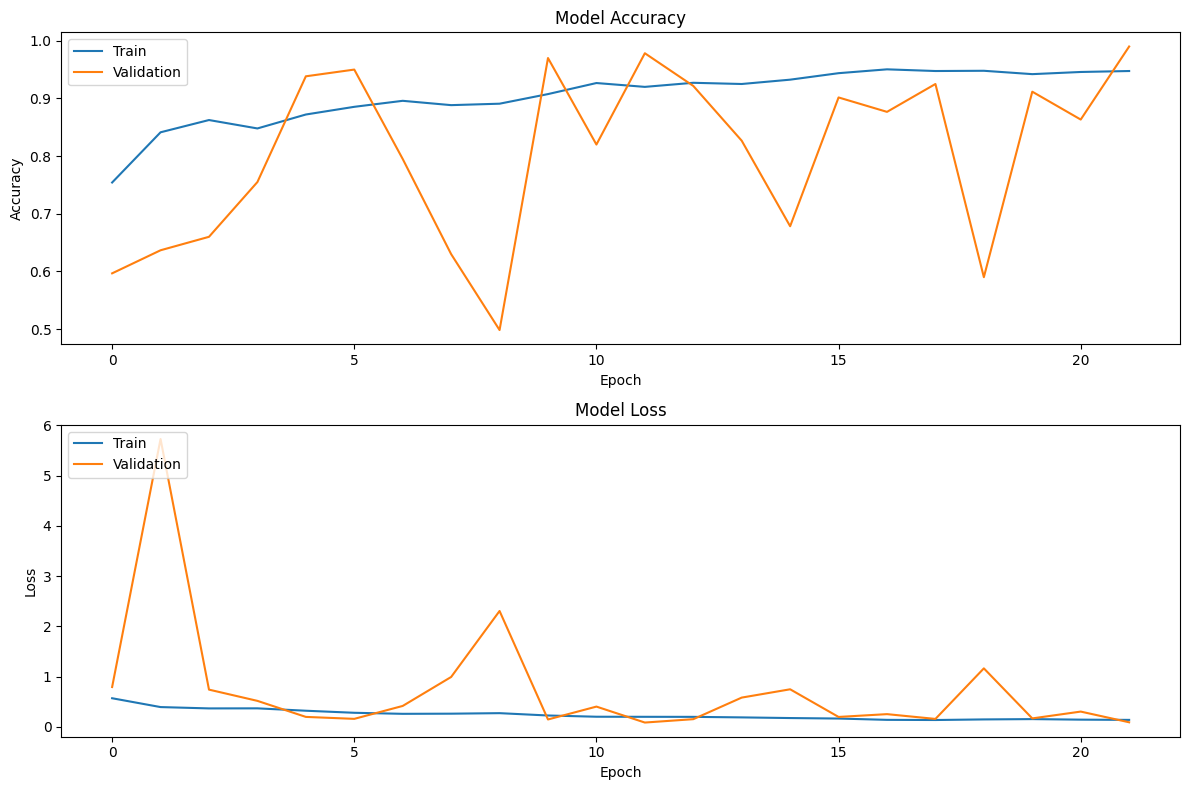

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Saving the CNN Model**

In [ ]:
# Saving the Model...its not compulsory as we are already saving the best model ..but if best model and last epoch model is diff so
model.save('kidney_stone_detection_model_cnn.h5')

**Testing Data**

In [ ]:
test_folder_path = "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test"
test_filenames = []          #filenames
test_categories = []         #categories

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)

    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False     #no shuffle because sequence is important so If we shuffled the data, it could misalign predictions with their actual labels during evaluation.
)

Found 900 validated image filenames belonging to 2 classes.


**Evaluate and predictions**

In [ ]:
#for batch predictions
steps = int(np.ceil(test_df.shape[0] / 15))  # Explicitly convert to int

predict = model.predict(test_generator, steps=steps)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step


In [ ]:
test_df['predicted category'] = np.argmax(predict, axis=-1)       #new colm created for predicted category
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [ ]:
test_df.head()

,filename,category,predicted category
0,Stone/Stone- (1010).jpg,Stone,Stone
1,Stone/Stone- (1007).jpg,Stone,Stone
2,Stone/Stone- (1003).jpg,Stone,Stone
3,Stone/Stone- (1004).jpg,Stone,Stone
4,Stone/Stone- (1009).jpg,Stone,Stone


**Visualize the predicted and actual data**

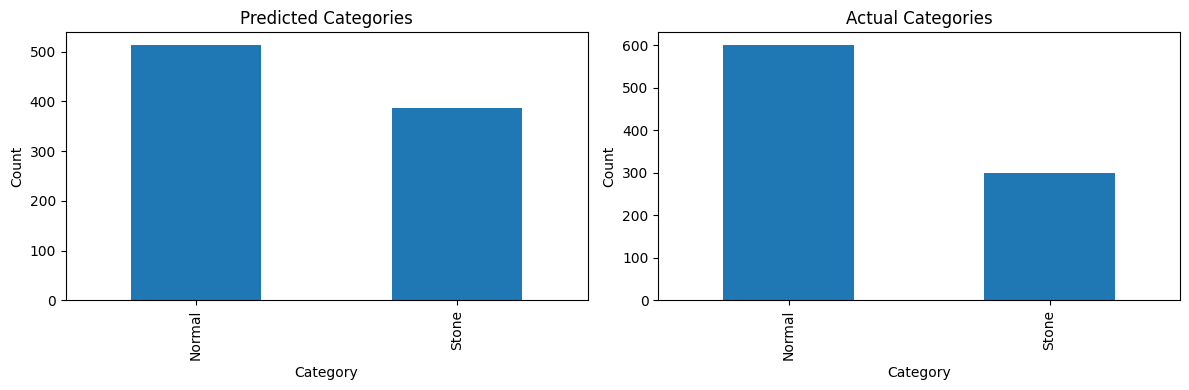

In [ ]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def predict_image(model_path, img_path, target_size=(150, 150)):

    # Load the trained model
    model = load_model("/content/model_best.h5")   #loads best model

    # Load the image and preprocess it (same as validation set)
    img = image.load_img("/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Stone/Stone- (1001).jpg", target_size=(150,150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values (same as training)..0 to 1 scaling from 0 to 255

    # Make a prediction
    prediction = model.predict(img_array)

    # Get the predicted class (assumes a softmax output)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Map predicted class to category
    class_labels = {0: 'Normal', 1: 'Stone'}  # Ensure these match your training labels
    predicted_category = class_labels.get(predicted_class, 'Unknown')

    return predicted_category

#predicted single image
result = predict_image("model_best.h5", "path_to_image.jpg")
print("Predicted class:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted class: Stone


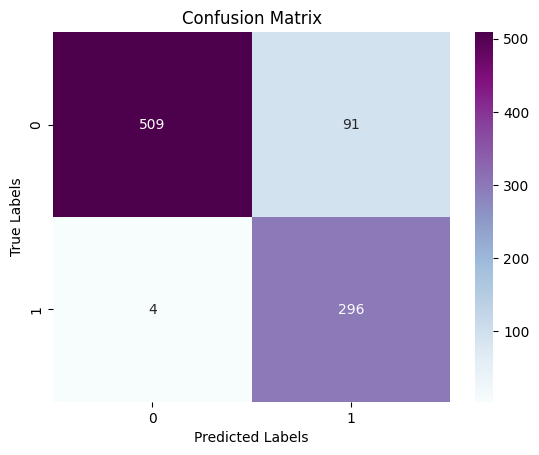

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.9578 - loss: 0.1309
Test Loss: 0.3565892279148102
Test Accuracy: 0.894444465637207


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from PIL import Image

# Load trained model
model = load_model('/content/model_best.h5')

# Function to predict image
def predict_image(img):
    img = img.resize((150, 150))  # Resize to model input size
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)
    predicted_category = {1: 'Stone', 0: 'Normal'}.get(predicted_class[0], 'Unknown')

    return predicted_category

# Streamlit UI
st.title("🖼️ Image Classification with CNN")

uploaded_file = st.file_uploader("Upload an Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Predict and display result
    result = predict_image(img)
    st.write(f"**Predicted Category:** {result}")


Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 8501 &
!cloudflared tunnel --url http://localhost:8501 --log-level debug






  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.122.7.244:8501

  Stopping...
/bin/bash: line 1: cloudflared: command not found


**SVM**

In [ ]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []          #list for images
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))    #read the image from full path joined
        if img is not None: #if image isnt there then rerurn none
            images_list.append(img)   #otherwise add full path in images_list
    return images_list

In [ ]:
#Reading train images from the normal and stone folders

train_normal = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Normal')
train_stone = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone')

In [ ]:
#Creating a list of labels for training
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [ ]:

# Define the path to your training images folders
train_images_normal = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Normal'
train_images_stone = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone'

# List all image files in both folders, filtering valid image files
image_files_normal = [f for f in os.listdir(train_images_normal) if f.endswith(('.jpg', '.png', '.jpeg'))]
image_files_stone = [f for f in os.listdir(train_images_stone) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Combine the lists of image files from both directories
image_files = image_files_normal + image_files_stone

# Debugging: Check how many images are found
print(f"Found {len(image_files)} images in the directories.")

# Feature extraction function using HOG
def extract_hog_features(img):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extract HOG features (only the feature vector)
    features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return features


# Store features for all images
feature_list_normal = []
feature_list_stone = []

# Loop through the images
for image_file in image_files:
    # Determine the folder based on the image file
    if image_file in image_files_normal:
        img_path = os.path.join(train_images_normal, image_file)
    else:
        img_path = os.path.join(train_images_stone, image_file)

    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
        continue  # Skip this image if it couldn't be loaded

    # Downscale the image (e.g., reduce size by 50%)
    original_height, original_width = img.shape[:2]
    new_width = original_width // 2
    new_height = original_height // 2
    downscaled_img = cv2.resize(img, (new_width, new_height))

    # Extract HOG features from the downscaled image
    features = extract_hog_features(downscaled_img)

    # Store the extracted features
    if image_file in image_files_normal:
        feature_list_normal.append(features)
    else:
        feature_list_stone.append(features)

# Now, `feature_list_normal` and `feature_list_stone` contain the extracted HOG features from downscaled images


Found 3000 images in the directories.


In [ ]:
print(img_path)


/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone/Stone- (998).jpg


hog => Histogram of oriented gradients (HOG) is a feature descriptor
1)focuses on the shape of an object, counting the occurrences of gradient orientation in each local region.
2)It then generates a histogram using the magnitude and orientation of the gradient.

In [ ]:
print(len(feature_list_normal))        #normal feature vectors extracted
print(len(feature_list_stone))    #stone feature vectors extracted

2000
1000


In [ ]:
#Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [ ]:
#Reading test images from the normal and stone folders
test_normal = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Normal')
test_stone = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Stone')

In [ ]:
#Creating a list of labels for testing
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [ ]:

from sklearn.model_selection import train_test_split

# Define paths for test images
test_images_normal = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Normal'
test_images_stone = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Stone'

# List all image files in both test folders
test_image_files_normal = [f for f in os.listdir(test_images_normal) if f.endswith(('.jpg', '.png', '.jpeg'))]
test_image_files_stone = [f for f in os.listdir(test_images_stone) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Combine the lists
test_image_files = test_image_files_normal + test_image_files_stone

# Initialize lists for features and labels
test_features = []
test_labels = []

# Set a fixed image size (ensure all images have the same dimensions)
FIXED_SIZE = (128, 128)  # Example fixed size, adjust as needed

# Function to extract HOG features
def extract_hog_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return features

# Process each image
for image_file in test_image_files:
    if image_file in test_image_files_normal:
        img_path = os.path.join(test_images_normal, image_file)
        label = 0  # Normal images label
    else:
        img_path = os.path.join(test_images_stone, image_file)
        label = 1  # Stone images label

    img = cv2.imread(img_path)

    if img is None:
        print(f"Error loading image: {img_path}")
        continue

    # Resize image to a fixed size
    img = cv2.resize(img, FIXED_SIZE)

    # Extract HOG features
    features = extract_hog_features(img)

    # Ensure feature vectors have the same shape
    if len(test_features) > 0 and len(features) != len(test_features[0]):
        print(f"Feature length mismatch for {image_file}. Expected {len(test_features[0])}, got {len(features)}")
        continue  # Skip inconsistent features

    test_features.append(features)
    test_labels.append(label)

# Convert to NumPy arrays
test_features = np.array(test_features, dtype=np.float32)  # Use dtype to prevent conversion issues
test_labels = np.array(test_labels)

# Ensure shape consistency
print(f"Final shape of test_features: {test_features.shape}")
print(f"Final shape of test_labels: {test_labels.shape}")

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(test_features, test_labels, test_size=0.2, shuffle=True, random_state=42)

# Train SVM
svc = SVC(kernel='rbf', C=1, gamma='auto')   #Gamma controls the influence of a single training example in RBF (Radial Basis Function) kernel...auto indicates that it depends on no. of features
svc.fit(X_train, y_train)

print("Training complete!")


Final shape of test_features: (900, 8100)
Final shape of test_labels: (900,)
Training complete!


In [ ]:
print(f"Number of normal features: {len(feature_list_normal)}")
print(f"Number of stone features: {len(feature_list_stone)}")
print(f"Number of normal test features: {len(test_feature_list_normal)}")
print(f"Number of stone test features: {len(test_feature_list_stone)}")
print(f"Total features: {len(features)}")
print(f"Labels length: {len(labels)}")


Number of normal features: 2000
Number of stone features: 1000
Number of normal test features: 600
Number of stone test features: 300
Total features: 8100
Labels length: 3000


In [ ]:
#Combining the features for both classes
test_features = test_feature_list_normal + test_feature_list_stone  # Concatenate test HOG features


In [ ]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(8100,)
(8100,)
(8100,)


above indicates that data has stores in flattened format in 8100 elements(image of 90*90 size is flattened as 8100)

In [ ]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [ ]:
print("Unique classes in y_train:", set(y_train))
print("Unique classes in y_valid:", set(y_valid))
print("First 10 predictions:", y_pred[:10])
print("First 10 actual labels:", y_valid[:10])
print("Last 10 predictions:", y_pred[-10:])
print("Last 10 actual labels:", y_valid[-10:])
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("Are train and validation sets different?", not np.array_equal(X_train, X_valid))


Unique classes in y_train: {0, 1}
Unique classes in y_valid: {0, 1}
First 10 predictions: [0 0 0 0 0 1 0 0 0 0]
First 10 actual labels: [0 1 0 0 0 1 0 0 0 0]
Last 10 predictions: [0 0 0 0 0 0 0 1 0 0]
Last 10 actual labels: [0 0 0 0 0 1 0 1 0 0]
X_train shape: (720, 8100)
X_valid shape: (180, 8100)
Are train and validation sets different? True


In [ ]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9111111111111111


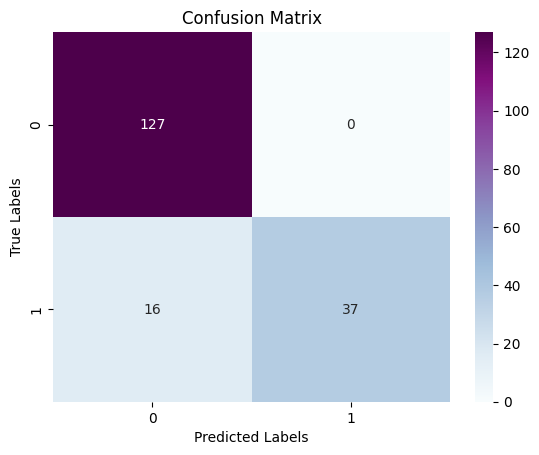

In [ ]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
import sklearn.externals
import joblib

# Save the model to a file
joblib.dump(svc, 'svc.pkl')

['svc.pkl']